**Big Data Analytics Project - Open Library Database**

Authors
1. Wibecka Oliver
2. Hiva Hojjati Moghaddam
3. Arunee Thongkrathok
*OBS: some of the code blocks were executed on different systems so some output is not represented, and some imports are doubly represented. This is a collection of all relevant code used.





## Set Up Environment:
Insert imports, set up Spark enviornment

In [ ]:
from pyspark.find_spark_home import _find_spark_home
from pyspark.sql import SparkSession
from pyspark import SparkConf, StorageLevel
import os

print(_find_spark_home())

/Users/Arro/opt/anaconda3/envs/BigDataPython310/lib/python3.10/site-packages/pyspark


In [ ]:
conf = SparkConf()\
    .setMaster('local[*]')\
    .set('spark.local.dir', '\spark-temp')\
    .set('spark.driver.memory', '6g')\
    .set('spark.executor.memory', '4g')\
    .set('spark.driver.maxResultSize', '2g')\
    .set('spark.pyspark.python', '/Users/Arro/opt/anaconda3/envs/bigData/lib/python3.10/site-packages/pyspark')\
    .set('spark.pyspark.driver.python', '/Users/Arro/opt/anaconda3/envs/bigData/lib/python3.10/site-packages/pyspark')


spark = SparkSession.builder.appName("OpenLibrary").config(conf=conf).getOrCreate()

sc = spark.sparkContext

for item in sc.getConf().getAll(): print(item)

('spark.driver.port', '60035')
('spark.driver.host', 'macbook-pro-61.lan')
('spark.app.submitTime', '1702901080067')
('spark.executor.memory', '4g')
('spark.app.id', 'local-1702901082298')
('spark.executor.id', 'driver')
('spark.pyspark.driver.python', '/Users/Arro/opt/anaconda3/envs/bigData/lib/python3.10/site-packages/pyspark')
('spark.pyspark.python', '/Users/Arro/opt/anaconda3/envs/bigData/lib/python3.10/site-packages/pyspark')
('spark.driver.extraJavaOptions', '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/s

# Create Inital DataFrame:
Read from the HDFS file, and clean up text file to a usable structure. This requires extracting the data nested within the metadata column, applying it to a JSON schema and then using that schema to create new feature columns which are easier to understand and use. We then drop the metadata columns for a cleaner overview.  This is done via a series of functions.italicized text

In [ ]:
from pyspark.sql.functions import expr
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, from_json
from pyspark.sql.types import StringType, StructType, StructField, ArrayType, IntegerType


# Function to read data from HDFS
def read_data(file_path):
    print(f"Reading data from: {file_path}")
    df = spark.read.option("delimiter", "\t").csv(file_path, header=False, inferSchema=True)
    return df

# Function to rename columns
def rename_columns(df, new_column_names):
    print("Renaming columns...")
    for i, col in enumerate(df.columns):
        df = df.withColumnRenamed(col, new_column_names[i])
    return df

# Function to define JSON schema
def define_json_schema():
    print("Defining JSON schema...")
    json_schema = StructType([
        StructField("title", StringType(), True),
        StructField("created", StructType([
            StructField("type", StringType(), True),
            StructField("value", StringType(), True),
        ]), True),
        StructField("covers", ArrayType(IntegerType()), True),
        StructField("subjects", ArrayType(StringType()), True),
        StructField("last_modified", StructType([
            StructField("type", StringType(), True),
            StructField("value", StringType(), True),
        ]), True),
        StructField("latest_revision", IntegerType(), True),
        StructField("key", StringType(), True),
        StructField("authors", ArrayType(StructType([
            StructField("type", StringType(), True),
            StructField("author", StructType([
                StructField("key", StringType(), True),
            ]), True),
        ])), True),
        StructField("type", StructType([
            StructField("key", StringType(), True),
        ]), True),
        StructField("revision", IntegerType(), True),
        StructField("description", StructType([
            StructField("type", StringType(), True),
            StructField("value", StringType(), True),
        ]), True),
        StructField("subject_places", ArrayType(StringType()), True),
        StructField("subject_people", ArrayType(StringType()), True),
        StructField("subject_times", ArrayType(StringType()), True),
    ])
    return json_schema

from pyspark.sql.functions import from_json

# Function to extract fields from metadata column
def extract_metadata_fields_detailed(df, json_schema):
    print("Extracting fields from metadata column...")
    # Parse "metadata" column from JSON string to JSON object
    df = df.withColumn("metadata_json", from_json(col("metadata"), json_schema))

    # Extract specific fields
    df = df.withColumn("title", col("metadata_json.title"))
    df = df.withColumn("created_value", col("metadata_json.created.value"))
    df = df.withColumn("covers", col("metadata_json.covers"))
    df = df.withColumn("latest_revision", col("metadata_json.latest_revision"))
    df = df.withColumn("description_value", col("metadata_json.description.value"))
    df = df.withColumn("subjects", col("metadata_json.subjects"))
    df = df.withColumn("subject_people", col("metadata_json.subject_people"))
    df = df.withColumn("subject_places", col("metadata_json.subject_places"))
    df = df.withColumn("subject_times", col("metadata_json.subject_times"))

    # Drop the original "metadata" and "metadata_json" columns
    df = df.drop("metadata", "metadata_json")

    return df


# Function to select desired columns
def select_columns(df):
    print("Selecting all columns...")
    selected_columns = [
        "type",
        "work_key",
        "revision",
        "created",
        "title",
        "created_value",
        "covers",
        "subjects",
        "latest_revision",
        "description_value",
        "subject_places",
        "subject_people",
        "subject_times"
    ]
    df_selected = df.select(selected_columns)
    return df_selected

# Function to show the first 5 rows of the DataFrame
def show_first_rows(df, num_rows=5):
    print(f"Showing the first {num_rows} rows of the DataFrame...")
    df.show(num_rows, truncate=False)

# Main execution
file_path = 'hdfs://localhost:9000/bigdata/works/*'

# Step 1: Read data
df = read_data(file_path)

Reading data from: hdfs://localhost:9000/bigdata/works/*


In [ ]:
# Step 2: Rename columns
new_column_names = ["type", "work_key", "revision", "created", "metadata"]
df = rename_columns(df, new_column_names)

Renaming columns...


In [ ]:
# Step 3: Define JSON schema
json_schema = define_json_schema()

Defining JSON schema...


In [ ]:
# Step 4: Extract fields from metadata column
df = extract_metadata_fields_detailed(df, json_schema)

Extracting fields from metadata column...


In [ ]:
# Step 5: Select desired columns
df_selected = select_columns(df)

# Step 6: Show the first 5 rows
show_first_rows(df_selected)

Selecting all columns...
Showing the first 5 rows of the DataFrame...


+----------+------------------+--------+--------------------------+-------------------------------------------------------+--------------------------+---------+-------------------------------+---------------+-----------------+-------------------------------------+--------------+--------------+
|type      |work_key          |revision|created                   |title                                                  |created_value             |covers   |subjects                       |latest_revision|description_value|subject_places                       |subject_people|subject_times |
+----------+------------------+--------+--------------------------+-------------------------------------------------------+--------------------------+---------+-------------------------------+---------------+-----------------+-------------------------------------+--------------+--------------+
|/type/work|/works/OL10000086W|3       |2010-04-28 06:54:19.472104|Les objets de Provence                          

# Clean Up Dataframe
Check for null values, drop unwanted columns.  


In [ ]:
for column in df.columns:
    null_count = df.where(col(column).isNull()).count()
    print(f"Column '{column}' has {null_count} null values.")

In [ ]:
# Function to drop unwanted columns and select desired columns
def drop_unwanted_columns(df):
    print("Dropping unwanted columns...")
    columns_to_drop = [
        "type",
        "revision",
        "created_value",
        "covers",
        "latest_revision",
        "description_value",
        "subject_places",
        "subject_people",
        "subject_times"
    ]

    # Drop unwanted columns and assign to df_selected
    df_selected = df.drop(*columns_to_drop).select("work_key", "created", "title", "subjects")
    return df_selected

# use clean dataframe
df_selected = drop_unwanted_columns(df)
df_selected.show()

Dropping unwanted columns...
+------------------+--------------------+--------------------+--------------------+
|          work_key|             created|               title|            subjects|
+------------------+--------------------+--------------------+--------------------+
|/works/OL10000086W|2010-04-28 06:54:...|Les objets de Pro...|                NULL|
|/works/OL10000117W|2010-04-28 06:54:...|Les duhamel sculp...|                NULL|
|/works/OL10000188W|2010-04-28 06:54:...|Désert, Jean-Mari...|                NULL|
|/works/OL10000312W|2009-12-11 01:57:...|       Diwan al-wajd|                NULL|
|/works/OL10000534W|2010-07-20 14:36:...|La libération de ...|[World War, 1939-...|
|/works/OL10000653W|2010-07-20 14:36:...|Ivan Lacković Croata|[Primitivism in a...|
|/works/OL10001106W|2010-04-28 06:54:...|Les Métiers de la...|                NULL|
|/works/OL10001113W|2020-12-07 07:45:...|  Le montage virtuel|[Motion pictures,...|
|/works/OL10001353W|2010-04-28 06:54:...|Coffre

We did not end up using this block of code as it ran for far too long with the entire dataset

In [ ]:
# for column in df.columns:
#     unique_count = df.select(column).distinct().count()
#     print(f"Column '{column}' has {unique_count} unique values.")

How many rows/books are in the entire dataset?

In [ ]:
num_rows = df_selected.count()

print(f"Number of rows in the DataFrame: {num_rows}")


Number of rows in the DataFrame: 33531695


# Data Analysis and Visualizations
## Subject analysis
Since the 'subjects' column was an array of strings, we had to extract each potential subject from within the subject column via the 'explode' function.

In [ ]:
from pyspark.sql.functions import explode

df_exploded = df.select(explode("subjects").alias("subject"))

subject_counts = df_exploded.groupBy("subject").count()

subject_counts_ordered = subject_counts.orderBy(col("count").desc())

subject_counts_ordered.show()

+--------------------+-------+
|             subject|  count|
+--------------------+-------+
|             History|2001397|
|           Biography| 754766|
|             Fiction| 605267|
|          Congresses| 513815|
|Politics and gove...| 480942|
|History and criti...| 431006|
| Juvenile literature| 276784|
|  Children's fiction| 254426|
| Law and legislation| 254347|
|         Exhibitions| 220498|
|            Catalogs| 211006|
|Criticism and int...| 207171|
| Economic conditions| 205339|
|   Social conditions| 194104|
|           Education| 191996|
|       United States| 188913|
|Description and t...| 187046|
|        Bibliography| 186177|
|Social life and c...| 179043|
|     Pictorial works| 163019|
+--------------------+-------+
only showing top 20 rows



Visualize using a bar chart


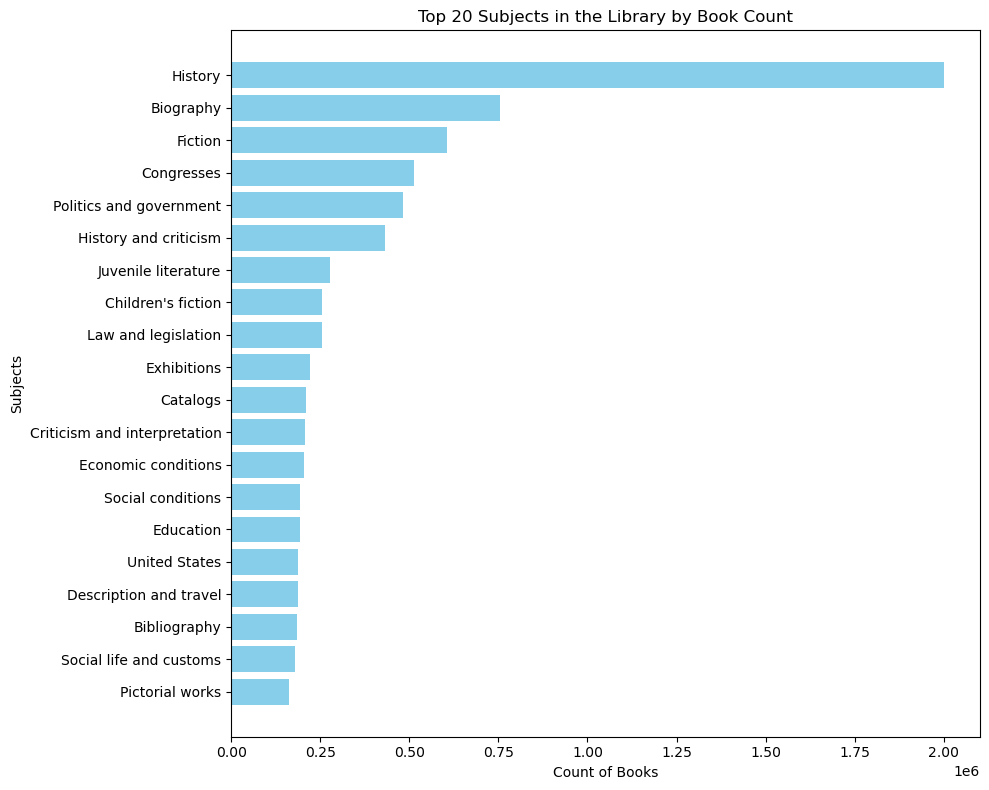

In [ ]:
import matplotlib.pyplot as plt

# Extract data for plotting
top_subjects_df = subject_counts_ordered.limit(20).toPandas()
subjects = top_subjects_df["subject"].tolist()
counts = top_subjects_df["count"].tolist()

# Creating the bar chart
plt.figure(figsize=(10, 8))
plt.barh(subjects, counts, color='skyblue')
plt.xlabel('Count of Books')
plt.ylabel('Subjects')
plt.title('Top 20 Subjects in the Library by Book Count')
plt.gca().invert_yaxis()  # to display the highest count at the top
plt.tight_layout()

# Save the plot to a file
plt.savefig('subjectBarChart.png')
plt.show()

visualize using a word map

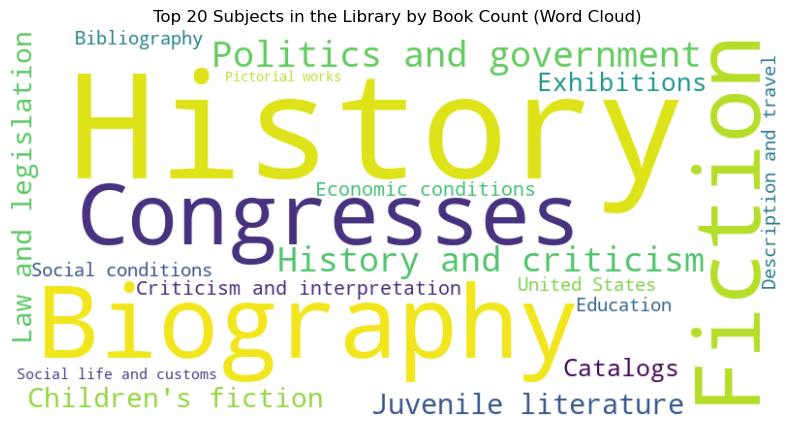

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Convert PySpark DataFrame to Pandas DataFrame
top_subjects_df = subject_counts_ordered.limit(20).toPandas()

# Create a dictionary from the Pandas DataFrame
top_subjects_dict = dict(zip(top_subjects_df["subject"], top_subjects_df["count"]))

# Creating the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_subjects_dict)

# Display the word cloud using Matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 20 Subjects in the Library by Book Count (Word Cloud)')
plt.show()



Visualize using a pie chart

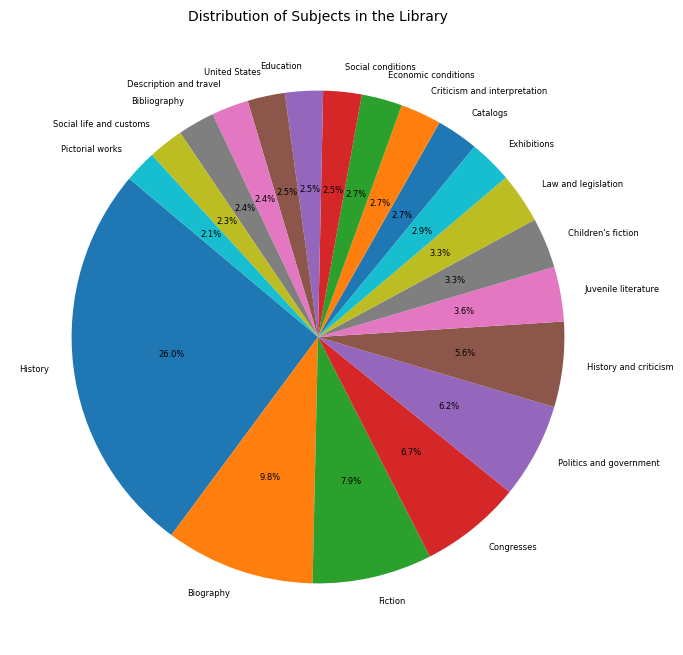

In [ ]:
import matplotlib.pyplot as plt

# Show as a pie chart
plt.figure(figsize=(10, 8))
plt.pie(counts, labels=subjects, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 6})
plt.title('Distribution of Subjects in the Library', fontsize=10)
plt.show()




## Language/Title Analysis

Out of curiosity we checked the total number of words in each title, then attempted to use the langdetect library to classify which languagues were most represented.


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, split, size

# Split the title into words
df_words = df_selected.withColumn("words", split(col("title"), " "))

# Calculate the number of words in each title
df_word_count = df_words.withColumn("word_count", size(col("words")))

# Calculate the average word count
average_word_count = df_word_count.agg({"word_count": "avg"}).collect()[0][0]

# Show the result
print("Average number of words in title:", average_word_count)


Average number of words in title: 5.555893252637542


In [ ]:

# Count the number of null values in the "title" column
null_count = df_selected.where(col("title").isNull()).count()

# Show the result
print("Number of null values in title:", null_count)


Number of null values in title: 47


# !ROADBLOCK!
The language detection code was unable to run in a reasonable timeframe on the entire database as shown below. We manually stopped calculations after 18 hours.

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from langdetect import detect
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# Function to detect language
def detect_language(title):
    try:
        return detect(title)
    except:
        return None

# Register the UDF
detect_language_udf = udf(detect_language, StringType())

#Use the 'title' column for language detection
df_with_language = df_selected.withColumn("language", detect_language_udf(col("title")))

# Group by language and count the number of titles for each language
language_counts = df_with_language.groupBy("language").count()

# Show the result
language_counts.show(truncate=False)


ERROR:root:KeyboardInterrupt while sending command.               (0 + 8) / 140]
Traceback (most recent call last):
  File "/Users/Arro/opt/anaconda3/envs/BigDataPython310/lib/python3.10/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/Users/Arro/opt/anaconda3/envs/BigDataPython310/lib/python3.10/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/Users/Arro/opt/anaconda3/envs/BigDataPython310/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

# !SOLUTION!
We instead ran the code on smaller sections of data and then compared to outputs to see if this sample was representative of the entire dataset (which it was!)
 The following analysis is done on a dataset of 1GB in size.

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from langdetect import detect
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# Function to detect language
def detect_language(title):
    try:
        return detect(title)
    except:
        return None

# Register the UDF
detect_language_udf = udf(detect_language, StringType())

# Use 'tite' column for language detection
df_with_language = df_selected.withColumn("language", detect_language_udf(col("title")))

# Group by language and count the number of titles for each language
language_counts = df_with_language.groupBy("language").count()

# Sort the DataFrame in descending order based on the count
language_counts = language_counts.orderBy(col("count").desc())

# Show the top 20 most common languages
top_20_languages = language_counts.limit(20)
top_20_languages.show(truncate=False)



+--------+------+
|language|count |
+--------+------+
|en      |994717|
|de      |167147|
|fr      |113476|
|es      |94686 |
|it      |61952 |
|id      |50875 |
|tl      |36157 |
|sw      |34956 |
|pt      |30524 |
|ca      |27645 |
|nl      |26789 |
|ro      |21657 |
|so      |20381 |
|af      |19502 |
|sl      |19031 |
|pl      |16970 |
|lv      |16431 |
|no      |15962 |
|fi      |15922 |
|da      |15507 |
+--------+------+



Visualize via a barchart


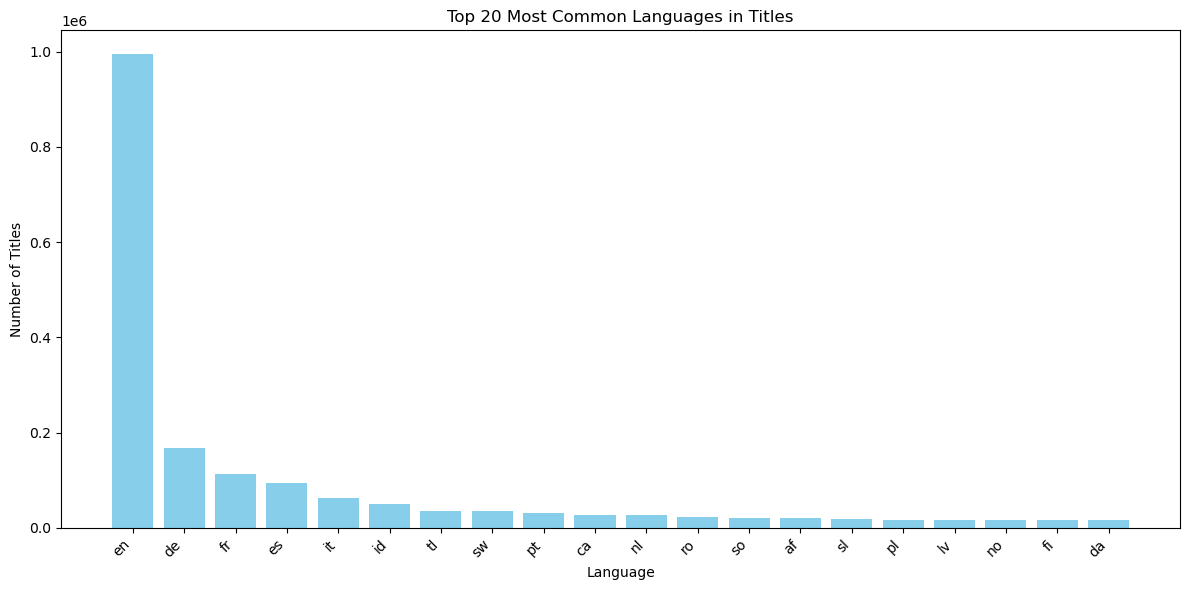

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

language_counts_pd = language_counts.toPandas()

# Filter out rows with None values in the language column
language_counts_pd = language_counts_pd.dropna(subset=['language'])

# Sort the DataFrame in descending order based on the count
language_counts_pd = language_counts_pd.sort_values(by='count', ascending=False)

# Select the top 20 most common languages
top_20_languages_pd = language_counts_pd.head(20)

# Plotting a bar chart
plt.figure(figsize=(12, 6))
plt.bar(top_20_languages_pd["language"], top_20_languages_pd["count"], color='skyblue')
plt.xlabel('Language')
plt.ylabel('Number of Titles')
plt.title('Top 20 Most Common Languages in Titles')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()





# Conclusion
It is difficult to analyze 17GB of data using a computer with only 8GB RAM. However, we were able to see how the majority of books in this database were catered to english speakers interested in historical content.
